# HRSC footprints issue

In the process of acquiring images from multiple experiments, I noticed some problems in HRSC footprints. 
This document expose the issues with the goal to report them to USGS/PDS/ODE people in charge.

As an example, the footprints we are going to see are in the region of Mawrth Vallis, Mars (~ 22.5<sup>o</sup>,343.5<sup>o</sup>; C180+E).

In [1]:
bbox = {
    'minlat': 22,
    'maxlat': 23,
    'westlon': 343,
    'eastlon': 344
}

## Data query

The we are eventually going to download comes from USGS/PDS; to know where the data is available for download (ie, URL),
we query USGS' ODE (https://ode.rsl.wustl.edu/) servers.
All those quirks -- query, retrieve, select, etc. -- are implemented in the lib.

First thing we do is to query what are the datasets the (NPT) lib supports; And then we go query for them products.

In [2]:
import requests

url = ('https://oderest.rsl.wustl.edu/live2/?query=product&results=fmpc&output=JSON&loc=f'
       '&minlat={minlat}'
       '&maxlat={maxlat}'
       '&westlon={westlon}'
       '&eastlon={eastlon}'
       '&target=MARS'
       '&ihid=MEX'
       '&iid=HRSC'
       '&pt=REFDR3').format(**bbox)

res = requests.get(url)

print("URL queried: '{}'".format(res.request.url))
assert res.status_code == 200, "Request failed."

URL queried: 'https://oderest.rsl.wustl.edu/live2/?query=product&results=fmpc&output=JSON&loc=f&minlat=22&maxlat=23&westlon=343&eastlon=344&target=MARS&ihid=MEX&iid=HRSC&pt=REFDR3'


In [3]:
_answer = res.json()
assert _answer['ODEResults']['Status'].lower() == 'success' and int(_answer['ODEResults']['Count']) > 1

products = _answer['ODEResults']['Products']['Product']
assert len(products) == int(_answer['ODEResults']['Count'])

print("{} data products found.".format(len(products)))

85 data products found.


> For simplicity, I'll filter for _Nadir_ images.

In [4]:
products_nadir = [p for p in products if 'ND3' in p['pdsid']]

print("{} (Nadir) images being used.".format(len(products_nadir))) 

9 (Nadir) images being used.


> Finally, let's check those footprints. First, we will check the "C0" (-180:180) footprints; then, the "GL" footprints (0:360). They are the same, but we like double-check anyways...

In [5]:
from geopandas import GeoDataFrame
import shapely

products_data_selected = []
for p in products_nadir:
    _data_selected = {k:p[k] for k in 'pdsid ihid iid pt ProductURL Footprints_cross_meridian Footprint_C0_geometry Footprint_GL_geometry'.split()}
    products_data_selected.append(_data_selected)
    
gdf = GeoDataFrame(products_data_selected)
gdf

,pdsid,ihid,iid,pt,ProductURL,Footprints_cross_meridian,Footprint_C0_geometry,Footprint_GL_geometry
0,H2229_0001_ND3.JP2,MEX,HRSC,REFDR3,https://ode.rsl.wustl.edu/mars/indexproductpag...,False,"POLYGON ((-19.076 11.606, -19.085 11.771, -19....","POLYGON ((340.924 11.606, 340.915 11.771, 340...."
1,H2938_0000_ND3.JP2,MEX,HRSC,REFDR3,https://ode.rsl.wustl.edu/mars/indexproductpag...,False,"POLYGON ((-12.48 37.056, -12.496 36.881, -12.5...","POLYGON ((347.52 37.056, 347.504 36.881, 347.4..."
2,H3308_0000_ND3.JP2,MEX,HRSC,REFDR3,https://ode.rsl.wustl.edu/mars/indexproductpag...,False,"POLYGON ((-15.039 27.395, -15.037 27.271, -15....","POLYGON ((344.961 27.395, 344.963 27.271, 344...."
3,H5145_0000_ND3.JP2,MEX,HRSC,REFDR3,https://ode.rsl.wustl.edu/mars/indexproductpag...,False,"MULTIPOLYGON (((-14.653 20.4432, -14.645 21.05...",MULTIPOLYGON (((343.9890983468124 20.983601702...
4,H5163_0009_ND3.JP2,MEX,HRSC,REFDR3,https://ode.rsl.wustl.edu/mars/indexproductpag...,False,GEOMETRYCOLLECTION (LINESTRING (-16.9439997673...,MULTIPOLYGON (((343.05614681710136 22.87723559...
5,H5181_0000_ND3.JP2,MEX,HRSC,REFDR3,https://ode.rsl.wustl.edu/mars/indexproductpag...,False,"POLYGON ((-16.379 27.952, -16.383 27.552, -16....","POLYGON ((343.621 27.952, 343.62 27.852, 343.6..."
6,HD633_0000_ND3.JP2,MEX,HRSC,REFDR3,https://ode.rsl.wustl.edu/mars/indexproductpag...,False,"MULTIPOLYGON (((-16.8285 19.6865, -16.83 19.81...",GEOMETRYCOLLECTION (POLYGON ((343.171499938967...
7,HH783_0009_ND3.JP2,MEX,HRSC,REFDR3,https://ode.rsl.wustl.edu/mars/indexproductpag...,False,"POLYGON ((-16.37 24.428, -16.37 24.321, -16.36...","POLYGON ((343.63 24.428, 343.63 24.375, 343.63..."
8,HH857_0000_ND3.JP2,MEX,HRSC,REFDR3,https://ode.rsl.wustl.edu/mars/indexproductpag...,False,"POLYGON ((-15.145 24.187, -15.145 24.135, -15....","POLYGON ((344.855 24.187, 344.855 24.135, 344...."


> I may be wrong, but I don't think footprints should be a `MULTIPOLYGON` or `GEOMETRYCOLLECTION`. Actually, anything different from a simple `POLYGON` to represent an _image_ seems wrong to me. Even more, the fact that some geometries are being represented by different objects -- in a non-stable way -- is quite worrisome.
> * See, for instance, geometries for products (`pdsid`) `H5163_0009_ND3.JP2` and `HD633_0000_ND3.JP2`.

> For the time being, I'm fixing that by considering the _ENVELOPE_ of those (wrong) geometries.

In [6]:
# Let's do the metadata selection again, but now we take the geometrical *envolope* of 
# the footprints defined under *geometry-collection* and *multi-polygon* geometries.

from geopandas import GeoDataFrame
import shapely

products_data_selected = []

for prod in products_nadir:
    _data_selected = {f:prod[f] for f in 'pdsid ihid iid pt ProductURL Footprints_cross_meridian'.split()}
    
    for geom_field in ('Footprint_C0_geometry','Footprint_GL_geometry'):
        _geom = shapely.wkt.loads(prod[geom_field])
        
        if (type(_geom) == shapely.geometry.GeometryCollection or type(_geom) == shapely.geometry.MultiPolygon):
            _geom = _geom.envelope

        _data_selected[geom_field] = _geom
        
    products_data_selected.append(_data_selected)
    
gdf = GeoDataFrame(products_data_selected)
gdf

,pdsid,ihid,iid,pt,ProductURL,Footprints_cross_meridian,Footprint_C0_geometry,Footprint_GL_geometry
0,H2229_0001_ND3.JP2,MEX,HRSC,REFDR3,https://ode.rsl.wustl.edu/mars/indexproductpag...,False,"POLYGON ((-19.076 11.606, -19.085 11.771, -19....","POLYGON ((340.924 11.606, 340.915 11.771, 340...."
1,H2938_0000_ND3.JP2,MEX,HRSC,REFDR3,https://ode.rsl.wustl.edu/mars/indexproductpag...,False,"POLYGON ((-12.48 37.056, -12.496 36.881, -12.5...","POLYGON ((347.52 37.056, 347.504 36.881, 347.4..."
2,H3308_0000_ND3.JP2,MEX,HRSC,REFDR3,https://ode.rsl.wustl.edu/mars/indexproductpag...,False,"POLYGON ((-15.039 27.395, -15.037 27.271, -15....","POLYGON ((344.961 27.395, 344.963 27.271, 344...."
3,H5145_0000_ND3.JP2,MEX,HRSC,REFDR3,https://ode.rsl.wustl.edu/mars/indexproductpag...,False,"POLYGON ((-16.093 17.364, -14.589 17.364, -14....",POLYGON ((343.90700006484985 17.36400032043457...
4,H5163_0009_ND3.JP2,MEX,HRSC,REFDR3,https://ode.rsl.wustl.edu/mars/indexproductpag...,False,POLYGON ((-17.019999980926507 19.4799995422363...,POLYGON ((342.9800000190735 19.479999542236328...
5,H5181_0000_ND3.JP2,MEX,HRSC,REFDR3,https://ode.rsl.wustl.edu/mars/indexproductpag...,False,"POLYGON ((-16.379 27.952, -16.383 27.552, -16....","POLYGON ((343.621 27.952, 343.62 27.852, 343.6..."
6,HD633_0000_ND3.JP2,MEX,HRSC,REFDR3,https://ode.rsl.wustl.edu/mars/indexproductpag...,False,"POLYGON ((-18.405 19.563, -16.827 19.563, -16....",POLYGON ((341.59499979019165 19.55699920654297...
7,HH783_0009_ND3.JP2,MEX,HRSC,REFDR3,https://ode.rsl.wustl.edu/mars/indexproductpag...,False,"POLYGON ((-16.37 24.428, -16.37 24.321, -16.36...","POLYGON ((343.63 24.428, 343.63 24.375, 343.63..."
8,HH857_0000_ND3.JP2,MEX,HRSC,REFDR3,https://ode.rsl.wustl.edu/mars/indexproductpag...,False,"POLYGON ((-15.145 24.187, -15.145 24.135, -15....","POLYGON ((344.855 24.187, 344.855 24.135, 344...."


<AxesSubplot:>

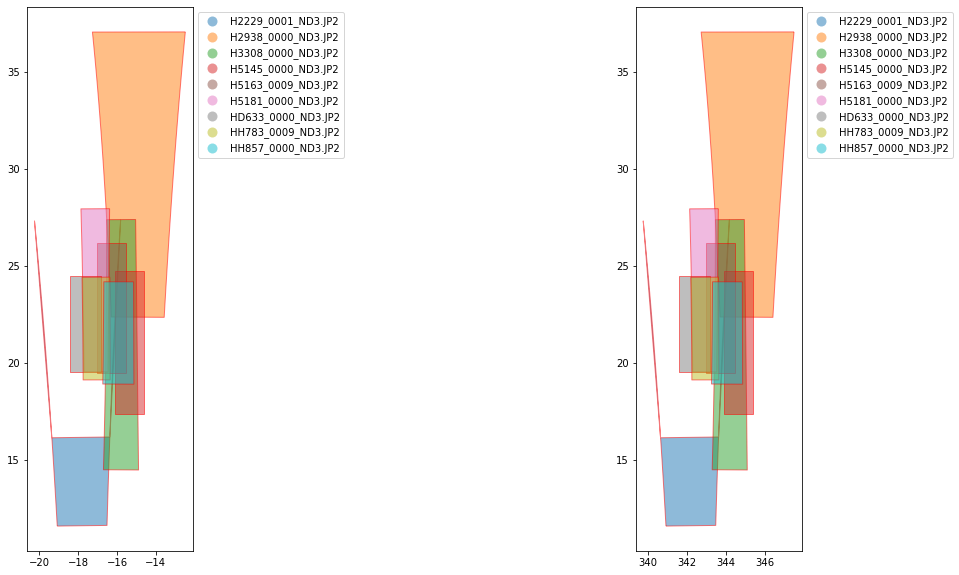

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [20,10]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)


(gdf.set_geometry('Footprint_C0_geometry')
    .plot(alpha=0.5, edgecolor='red', column='pdsid',
          legend=True, legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
          ax=ax1)
)

(gdf.set_geometry('Footprint_GL_geometry')
    .plot(alpha=0.5, edgecolor='red', column='pdsid',
          legend=True, legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
          ax=ax2)
)

> Footprint `H2229_0001_ND3` show a clear strange/erroneous shape.

## Conclusion

We've shown some erroneous behaviour of footprints representing Mars Express' HRSC (_refdr3_) image data products as provided
by ODE REST API (https://oderest.rsl.wustl.edu/).

Specifically, _two_ are the issues here exposed (as seen on _three_ data products):

* _Some_ data product footprints are represented by different geometrical object/format  -- Multi-polygon or geometry-collection -- depending on the coordinates reference. Data products `H5163_0009_ND3.JP2` and `HD633_0000_ND3.JP2` present such behaviour on (geometry) attributes `Footprint_GL_geometry` and `Footprint_C0_geometry`;
  - None of those images/footprints cross a meridian -- is worth noticing.
  
* _Some_ data product footprints -- `H2229_0001_ND3.JP2`, for example -- clearly do not properly represent an image as can be seeing from the plot(s) provided.

As _third_ (and very worrisome) issue underlying the whole should be noticed: the _intermitent_ factor; the two issues just discussed show some erratic behaviour.